Notebook to plot time histograms of select 2D variables.

James Ruppert  
11/12/2024

### Main Settings

In [ ]:
# from netCDF4 import Dataset
import xarray as xr
import numpy as np
from matplotlib import rc, ticker, colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from read_wrf_ideal import *
import seaborn as sns
import cmocean

In [2]:
# Which test to process/analyze
test_process = "large2km"
# test_process = "ctl"

scdir = "/glade/derecho/scratch/ruppert/wrf-ideal/"
file_dir = scdir+test_process+"/post_proc/"

In [3]:
# Time step info
npd = 24*12 # every 5 min
time_step = 1./npd
time0 = np.datetime64("2007-06-01T00:00")
time_step_td64 = np.timedelta64(int(time_step*24*60), 'm')

### Plotting

In [4]:
# For plotting

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [5]:
var_str = 'LWUPT'
ds = xr.open_dataset(file_dir+var_str+".nc")
var = ds[var_str]

# datetime array of simulation time
nt = var.shape[0]
time1 = time0 + time_step_td64*nt
times = np.arange(time0, time1, time_step_td64, dtype='datetime64[m]')
# times = np.arange(0, nt*time_step, time_step) # float array of simulation day

In [6]:
var.shape

(6912, 799, 799)

In [7]:
def compute_histogram(invar, bins):
    nt = invar.shape[0]
    nbin = len(bins)
    hist_density=np.zeros((nt,nbin-1))
    for it in range(nt):
        count, bin_edges = np.histogram(invar[it,:], bins=bins, density=True)
        hist_density[it,:] = count
    return hist_density, bin_edges

nbin=40
fmin=0
fmax=var.max()
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)
hist_density, bin_edges = compute_histogram(var.values, bins)

: 

In [23]:
# Create a function to plot a time-histogram of the data

# def plot_time_series(invar):

pltvar = hist_density

# create figure
fig, ax1 = plt.subplots(figsize=(6,3))

# Time labels
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

ax1.set_title(var_str)#, fontsize=20)
ax1.set_xlabel('Date')
ax1.set_ylabel(var.attrs['units'])

norm=colors.Normalize(vmin=0, vmax=0.25)
cmap=cmocean.cm.rain
im = ax1.pcolormesh(times, bin_edges, pltvar, cmap=cmap, norm=norm)
# if plot_cbar:
fig.colorbar(im, ax=ax1, label='Density', shrink=0.75)

# figname=figdir+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
# plt.savefig(figname,dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()
# return None

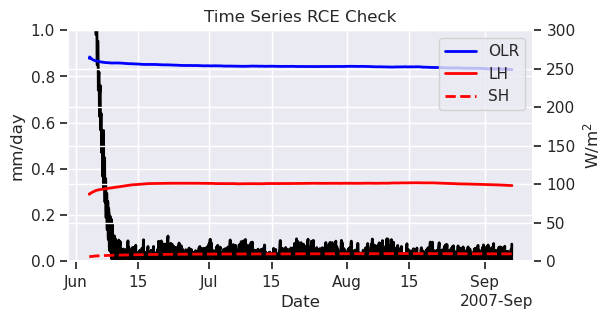

In [24]:
if do_plot_tser:

    wrffile_read = Dataset(timeseries_file)

    # Read in sfc fluxes
    for ifile in wrffiles[0:1]:
        ds = Dataset(ifile)
        hfx = getvar(ds, 'HFX', timeidx=ALL_TIMES)

    # General specs
    nt_ts = wrffile_read.dimensions['XTIME'].size
    times = np.squeeze(wrffile_read.variables['XTIME']) # minutes since model start
    # time_days = times/60/24 # days
    time_0 = np.datetime64('2007-06-01T00:00', 'm')
    times = time_0+times.astype('timedelta64[m]')

    # Read in variables

    rainnc = np.squeeze(wrffile_read.variables['RAINNC']) # accumulated rain, mm
    olr_ts = np.squeeze(wrffile_read.variables['OLR']) # W/m2
    sh_ts = np.squeeze(wrffile_read.variables['HFX']) # W/m2
    lh_ts = np.squeeze(wrffile_read.variables['LH']) # W/m2

    wrffile_read.close()

    # Rain rate as centered difference
    rain_ts=np.zeros(nt_ts)
    rain_ts[1:nt_ts-2] = (rainnc[2:nt_ts-1] - rainnc[0:nt_ts-3])*0.5
    rain_ts[[0,nt_ts-1]] = np.nan
    rain_ts *= npd # mm/output_dt --> mm/day

    plot_time_series(rain_ts, olr_ts, lh_ts, sh_ts, times)